In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import datetime 
import warnings
import csv
warnings.simplefilter(action='ignore', category=FutureWarning)
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv


In [2]:
items = pd.read_csv('../input/competitive-data-science-predict-future-sales/items.csv')
item_cat = pd.read_csv ('../input/competitive-data-science-predict-future-sales/item_categories.csv')
trainset1 = pd.read_csv('../input/competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('../input/competitive-data-science-predict-future-sales/shops.csv')
testset= pd.read_csv('../input/competitive-data-science-predict-future-sales/test.csv')

In [3]:
trainset1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


In [4]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22170 entries, 0 to 22169
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   item_name         22170 non-null  object
 1   item_id           22170 non-null  int64 
 2   item_category_id  22170 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 519.7+ KB


In [5]:
item_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84 entries, 0 to 83
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   item_category_name  84 non-null     object
 1   item_category_id    84 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [6]:
shops.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   shop_name  60 non-null     object
 1   shop_id    60 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB


In [7]:
trainset1.shape

(2935849, 6)

In [8]:
display(trainset1, item_cat, items, shops)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0
...,...,...,...,...,...,...
2935844,10.10.2015,33,25,7409,299.00,1.0
2935845,09.10.2015,33,25,7460,299.00,1.0
2935846,14.10.2015,33,25,7459,349.00,1.0
2935847,22.10.2015,33,25,7440,299.00,1.0


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
...,...,...
79,Служебные,79
80,Служебные - Билеты,80
81,Чистые носители (шпиль),81
82,Чистые носители (штучные),82


,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4
5,"Вологда ТРЦ ""Мармелад""",5
6,"Воронеж (Плехановская, 13)",6
7,"Воронеж ТРЦ ""Максимир""",7
8,"Воронеж ТРЦ Сити-Парк ""Град""",8
9,Выездная Торговля,9


In [9]:
trainset2=pd.merge(items, trainset1)

In [10]:
trainset3=pd.merge(item_cat, trainset2)

In [11]:
train=pd.merge(shops, trainset3)

In [12]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column              Dtype  
---  ------              -----  
 0   shop_name           object 
 1   shop_id             int64  
 2   item_category_name  object 
 3   item_category_id    int64  
 4   item_name           object 
 5   item_id             int64  
 6   date                object 
 7   date_block_num      int64  
 8   item_price          float64
 9   item_cnt_day        float64
dtypes: float64(2), int64(4), object(4)
memory usage: 246.4+ MB


In [13]:
train.shape

(2935849, 10)

In [14]:
train.describe()

,shop_id,item_category_id,item_id,date_block_num,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,3.300173e+01,4.000138e+01,1.019723e+04,1.456991e+01,8.908532e+02,1.242641e+00
std,1.622697e+01,1.710076e+01,6.324297e+03,9.422988e+00,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,2.200000e+01,2.800000e+01,4.476000e+03,7.000000e+00,2.490000e+02,1.000000e+00
50%,3.100000e+01,4.000000e+01,9.343000e+03,1.400000e+01,3.990000e+02,1.000000e+00
75%,4.700000e+01,5.500000e+01,1.568400e+04,2.300000e+01,9.990000e+02,1.000000e+00
max,5.900000e+01,8.300000e+01,2.216900e+04,3.300000e+01,3.079800e+05,2.169000e+03


In [15]:
train.isnull().sum()

shop_name             0
shop_id               0
item_category_name    0
item_category_id      0
item_name             0
item_id               0
date                  0
date_block_num        0
item_price            0
item_cnt_day          0
dtype: int64

In [16]:
train['shop_name'].unique()

array(['!Якутск Орджоникидзе, 56 фран', '!Якутск ТЦ "Центральный" фран',
       'Адыгея ТЦ "Мега"', 'Балашиха ТРК "Октябрь-Киномир"',
       'Волжский ТЦ "Волга Молл"', 'Вологда ТРЦ "Мармелад"',
       'Воронеж (Плехановская, 13)', 'Воронеж ТРЦ "Максимир"',
       'Воронеж ТРЦ Сити-Парк "Град"', 'Выездная Торговля',
       'Жуковский ул. Чкалова 39м?', 'Жуковский ул. Чкалова 39м²',
       'Интернет-магазин ЧС', 'Казань ТЦ "Бехетле"',
       'Казань ТЦ "ПаркХаус" II', 'Калуга ТРЦ "XXI век"',
       'Коломна ТЦ "Рио"', 'Красноярск ТЦ "Взлетка Плаза"',
       'Красноярск ТЦ "Июнь"', 'Курск ТЦ "Пушкинский"',
       'Москва "Распродажа"', 'Москва МТРЦ "Афи Молл"',
       'Москва Магазин С21', 'Москва ТК "Буденовский" (пав.А2)',
       'Москва ТК "Буденовский" (пав.К7)', 'Москва ТРК "Атриум"',
       'Москва ТЦ "Ареал" (Беляево)', 'Москва ТЦ "МЕГА Белая Дача II"',
       'Москва ТЦ "МЕГА Теплый Стан" II',
       'Москва ТЦ "Новый век" (Новокосино)', 'Москва ТЦ "Перловский"',
       'Москва Т

In [17]:
train['shop_id'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [18]:
train['item_category_name'].unique()

array(['PC - Гарнитуры/Наушники', 'Аксессуары - PS2', 'Аксессуары - PS3',
       'Аксессуары - PS4', 'Аксессуары - PSP', 'Аксессуары - PSVita',
       'Аксессуары - XBOX 360', 'Игровые консоли - PS3',
       'Игровые консоли - PSP', 'Игровые консоли - PSVita',
       'Игровые консоли - XBOX 360', 'Игры - PS3', 'Игры - PSP',
       'Игры - PSVita', 'Игры - XBOX 360', 'Игры - Аксессуары для игр',
       'Игры PC - Дополнительные издания',
       'Игры PC - Коллекционные издания', 'Игры PC - Стандартные издания',
       'Карты оплаты - Live!', 'Карты оплаты - PSN', 'Кино - Blu-Ray',
       'Кино - Blu-Ray 3D', 'Кино - DVD', 'Кино - Коллекционное',
       'Книги - Аудиокниги', 'Книги - Аудиокниги 1С',
       'Книги - Методические материалы 1С',
       'Музыка - CD локального производства',
       'Музыка - CD фирменного производства', 'Музыка - MP3',
       'Музыка - Музыкальное видео', 'Музыка - Подарочные издания',
       'Подарки - Гаджеты, роботы, спорт', 'Подарки - Мягкие игрушки',
  

In [19]:
train['item_name'].unique()

array(['Наушники PHILIPS SBC HC8680',
       'Pelican. Геймпад Nerf Wireless Controller PS2 (assorted colors)',
       'PS Move Controller (Контроллер движений)', ...,
       'LINKIN PARK  Reanimation', 'Ранетки (mp3-CD) (Jewel)',
       'Наш Сад, UPG с версии 6.0 до версии 10.0'], dtype=object)

In [20]:
train['item_id'].unique()

array([16255,  5740,  5570, ...,  4426, 18018, 16270])

In [21]:
train['shop_name'].nunique()

60

In [22]:
train['shop_id'].nunique()

60

In [23]:
train['item_category_name'].nunique()

84

In [24]:
train['item_name'].nunique()

21807

In [25]:
train['item_id'].nunique()

21807

In [26]:
train_set=train.copy()

In [27]:
corrmat=train_set.corr()
corrmat

,shop_id,item_category_id,item_id,date_block_num,item_price,item_cnt_day
shop_id,1.000000,0.019380,0.029396,0.019273,-0.024034,-0.005230
item_category_id,0.019380,1.000000,0.369431,0.029128,-0.253554,0.014768
item_id,0.029396,0.369431,1.000000,0.009356,-0.134104,0.016650
date_block_num,0.019273,0.029128,0.009356,1.000000,0.095010,0.009402
item_price,-0.024034,-0.253554,-0.134104,0.095010,1.000000,0.011197
item_cnt_day,-0.005230,0.014768,0.016650,0.009402,0.011197,1.000000


<AxesSubplot:>

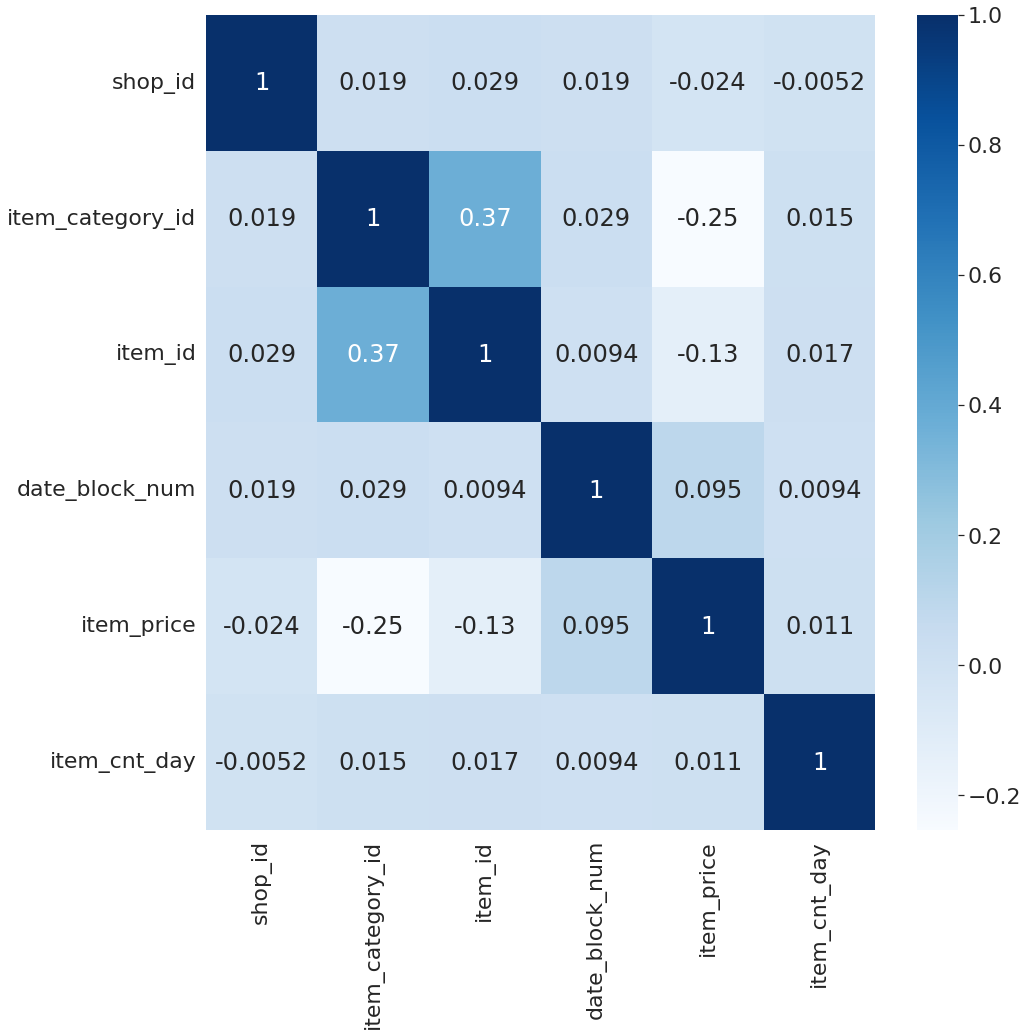

In [28]:
plt.figure(figsize=(15, 15))
sns.set(font_scale=2)
sns.heatmap(train_set.corr(), annot=True, cmap="Blues", fmt= ".2g")

In [29]:
negative_price=train_set[train_set["item_price"] < 0]
negative_price

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
1644072,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,15.05.2013,4,-1.0,1.0


In [30]:
price_2973=train_set[(train_set["shop_id"]== 32) & (train_set["item_category_name"]=="Игры - PS3") & (train_set["item_id"]== 2973 ) & (train_set["date_block_num"]== 4)]
price_2973

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
1644071,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,23.05.2013,4,1249.0,1.0
1644072,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,15.05.2013,4,-1.0,1.0
1644073,"Москва ТЦ ""Серебряный Дом""",32,Игры - PS3,19,"DmC Devil May Cry [PS3, русские субтитры]",2973,06.05.2013,4,2499.0,1.0


In [31]:
price_mean=price_2973[(price_2973.shop_id==32)&(price_2973.item_id==2973)&(price_2973.date_block_num==4)&(price_2973.item_price>0)]
price_mean.item_price.mean()

1874.0

In [32]:
train_set.at[1644072,'item_price']= 1849

In [33]:
negative_item_cnt_day=train_set[train_set["item_cnt_day"] < 0]
negative_item_cnt_day

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
15728,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной серый мет...,5637,06.10.2013,9,2590.00,-1.0
15757,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной темно-кра...,5642,01.12.2013,11,2490.00,-1.0
15771,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной черный (D...,5643,02.01.2013,0,2385.21,-1.0
16462,"Адыгея ТЦ ""Мега""",2,Аксессуары - XBOX 360,6,X360: Super ZOOM [только для Kinect],7882,12.07.2013,6,1390.00,-1.0
16589,"Адыгея ТЦ ""Мега""",2,Аксессуары - XBOX 360,6,X360: Геймпад проводной чёрный - Controller BL...,7894,23.02.2014,13,1490.00,-1.0
...,...,...,...,...,...,...,...,...,...,...
2934435,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Бухгалтерия 8. Базовая версия,482,13.11.2013,10,3300.00,-1.0
2934499,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Предпр.8.2.Версия для обучения программиров...,791,01.02.2013,1,600.00,-1.0
2934524,"Ярославль ТЦ ""Альтаир""",59,Программы - 1С:Предприятие 8,73,1С:Управление торговлей 8. Базовая версия,835,05.03.2014,14,4600.00,-1.0
2934594,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,ESET NOD32 Smart Security - продление лицензии...,3141,12.03.2014,14,1180.00,-1.0


In [34]:
cond = train_set['item_cnt_day'] < 0
check= train_set.loc[cond,'item_cnt_day'] = 0
check

0

Text(0.5, 1.0, 'Outliers in item_price')

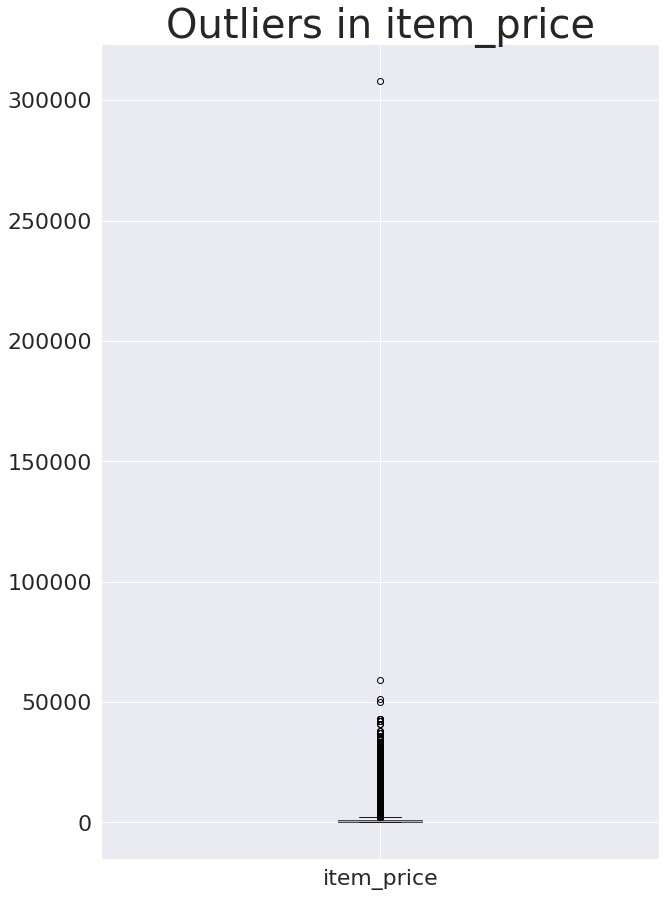

In [35]:
plt.figure(figsize=(10, 15))
train_set.boxplot(['item_price'])
plt.title('Outliers in item_price', fontsize = 40)

In [36]:
print("Maximum possible price",train_set['item_price'].mean() + 3*train_set['item_price'].std())
print("Lowest possible price",train_set['item_price'].mean() - 3*train_set['item_price'].std())

Maximum possible price 6080.2527912390315
Lowest possible price -4298.545065560299


In [37]:
hp=max(train_set.item_price)
print("Highest price :", hp)
lp=min(train_set.item_price)
print("Lowest price: ", lp)

Highest price : 307980.0
Lowest price:  0.07


In [38]:
highest_price=train_set[train_set["item_price"] > 6080]
highest_price

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
310,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,18.01.2013,0,6254.00,2.0
311,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,19.01.2013,0,6254.00,1.0
312,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,30.01.2013,0,6254.00,3.0
313,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,31.01.2013,0,6254.00,1.0
314,"!Якутск Орджоникидзе, 56 фран",0,Аксессуары - XBOX 360,6,Xbox 360 Kinect Sensor Xbox 360 CS/EL/HU/PL/RU...,7956,10.02.2013,1,6254.00,1.0
...,...,...,...,...,...,...,...,...,...,...
2929953,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Гаджеты, роботы, спорт",62,Шпионский танк Spy-C Танк,21994,10.03.2013,2,6648.35,1.0
2935213,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,15.08.2015,31,6290.00,1.0
2935214,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,25.09.2015,32,6390.00,1.0
2935215,"Ярославль ТЦ ""Альтаир""",59,Программы - Для дома и офиса,75,Win 8.1 32-bit/64-bit Russian Russia Only DVD,7812,07.09.2015,32,6290.00,1.0


In [39]:
train_set = train_set[train_set['item_price'] < 100000]

Text(0.5, 1.0, 'Outliers in item_cnt_day')

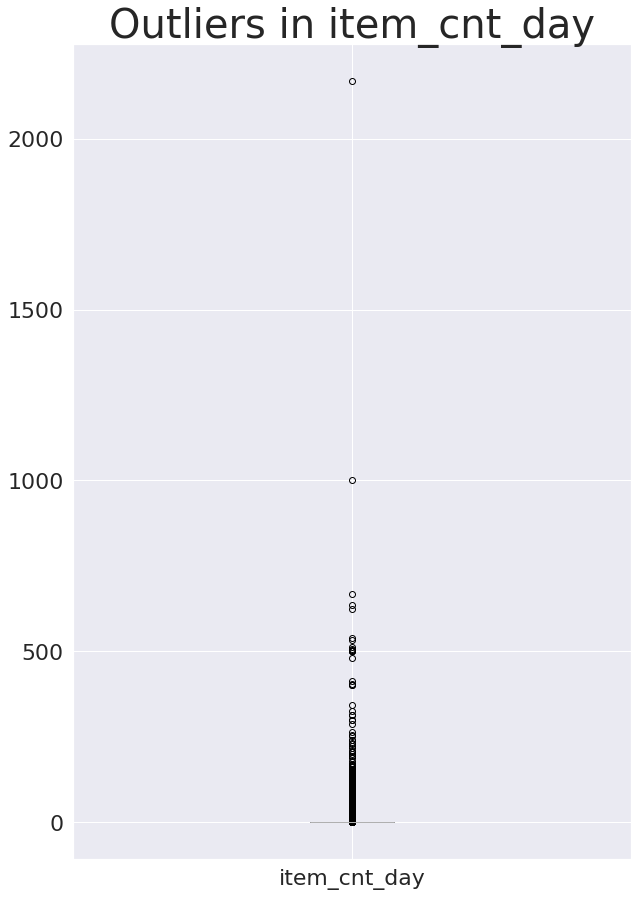

In [40]:
plt.figure(figsize=(10, 15))
train_set.boxplot(['item_cnt_day'])
plt.title('Outliers in item_cnt_day', fontsize = 40)

In [41]:
print("Maximum possible number of products sold",train_set['item_cnt_day'].mean() + 3*train_set['item_cnt_day'].std())
print("Lowest possible number of products sold",train_set['item_cnt_day'].mean() - 3*train_set['item_cnt_day'].std())

Maximum possible number of products sold 9.096348775703945
Lowest possible number of products sold -6.605929653188066


In [42]:
hps=max(train_set.item_cnt_day)
print("Highest number of products sold :", hps)
lps=min(train_set.item_cnt_day)
print("Lowest number of products sold: ", lps)

Highest number of products sold : 2169.0
Lowest number of products sold:  0.0


In [43]:
highest_price=train_set[train_set["item_cnt_day"] > 9]
highest_price

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day
2556,"!Якутск Орджоникидзе, 56 фран",0,Игры PC - Стандартные издания,30,"Crysis 3 [PC, русская версия]",2445,22.02.2013,1,942.0,10.0
4943,"!Якутск Орджоникидзе, 56 фран",0,Кино - DVD,40,"ДЖЕНТЛЬМЕНЫ, УДАЧИ!",11000,16.02.2013,1,247.0,11.0
5993,"!Якутск Орджоникидзе, 56 фран",0,Кино - DVD,40,ОГРАБЛЕНИЕ КАЗИНО,16482,02.02.2013,1,247.0,10.0
15443,"!Якутск ТЦ ""Центральный"" фран",1,Чистые носители (штучные),82,Компактдиск Mirex CD-R 700 Мб 52x Slim case MA...,13345,25.01.2013,0,13.0,11.0
15464,"!Якутск ТЦ ""Центральный"" фран",1,Чистые носители (штучные),82,"Компактдиск Mirex DVD+R Dual Layer 8,5 Гб 8x S...",13351,17.01.2013,0,41.0,13.0
...,...,...,...,...,...,...,...,...,...,...
2933480,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,05.10.2013,9,5.0,12.0
2933523,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,28.12.2013,11,5.0,13.0
2933825,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,29.11.2014,22,5.0,10.0
2933908,"Ярославль ТЦ ""Альтаир""",59,"Подарки - Сумки, Альбомы, Коврики д/мыши",71,Фирменный пакет майка 1С Интерес белый (34*42)...,20949,14.02.2015,25,5.0,13.0


In [44]:
train_set = train_set[train_set['item_cnt_day'] < 1000]

In [45]:
train_set['Sales'] = (train_set["item_price"] * train_set["item_cnt_day"])

In [46]:
train_set['date'] = pd.to_datetime(train_set['date'])
days = []
months = []
years = []

for day in train_set['date']:
    days.append(day.day)
for month in train_set['date']:
    months.append(month.month)    
for year in train_set['date']:
    years.append(year.year)

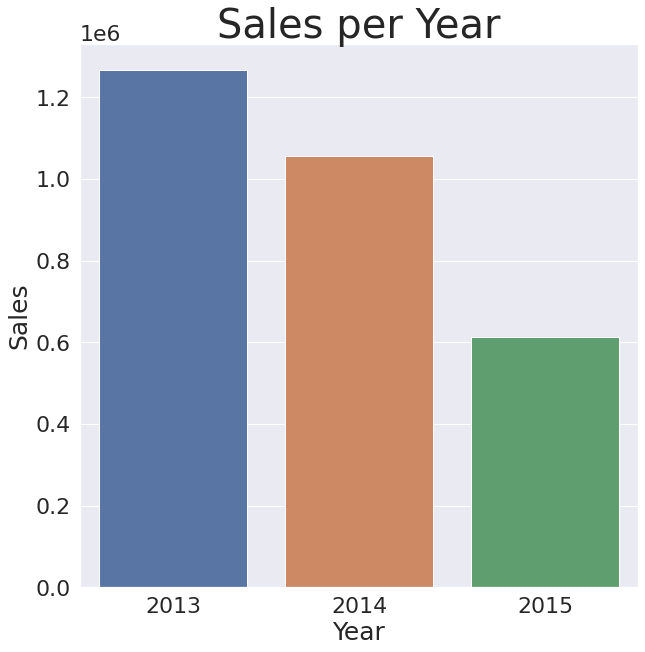

In [47]:
plt.figure(figsize=(10,10))
sns.countplot(years)
plt.title('Sales per Year', fontsize = 40)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Sales', fontsize = 25)
plt.show()

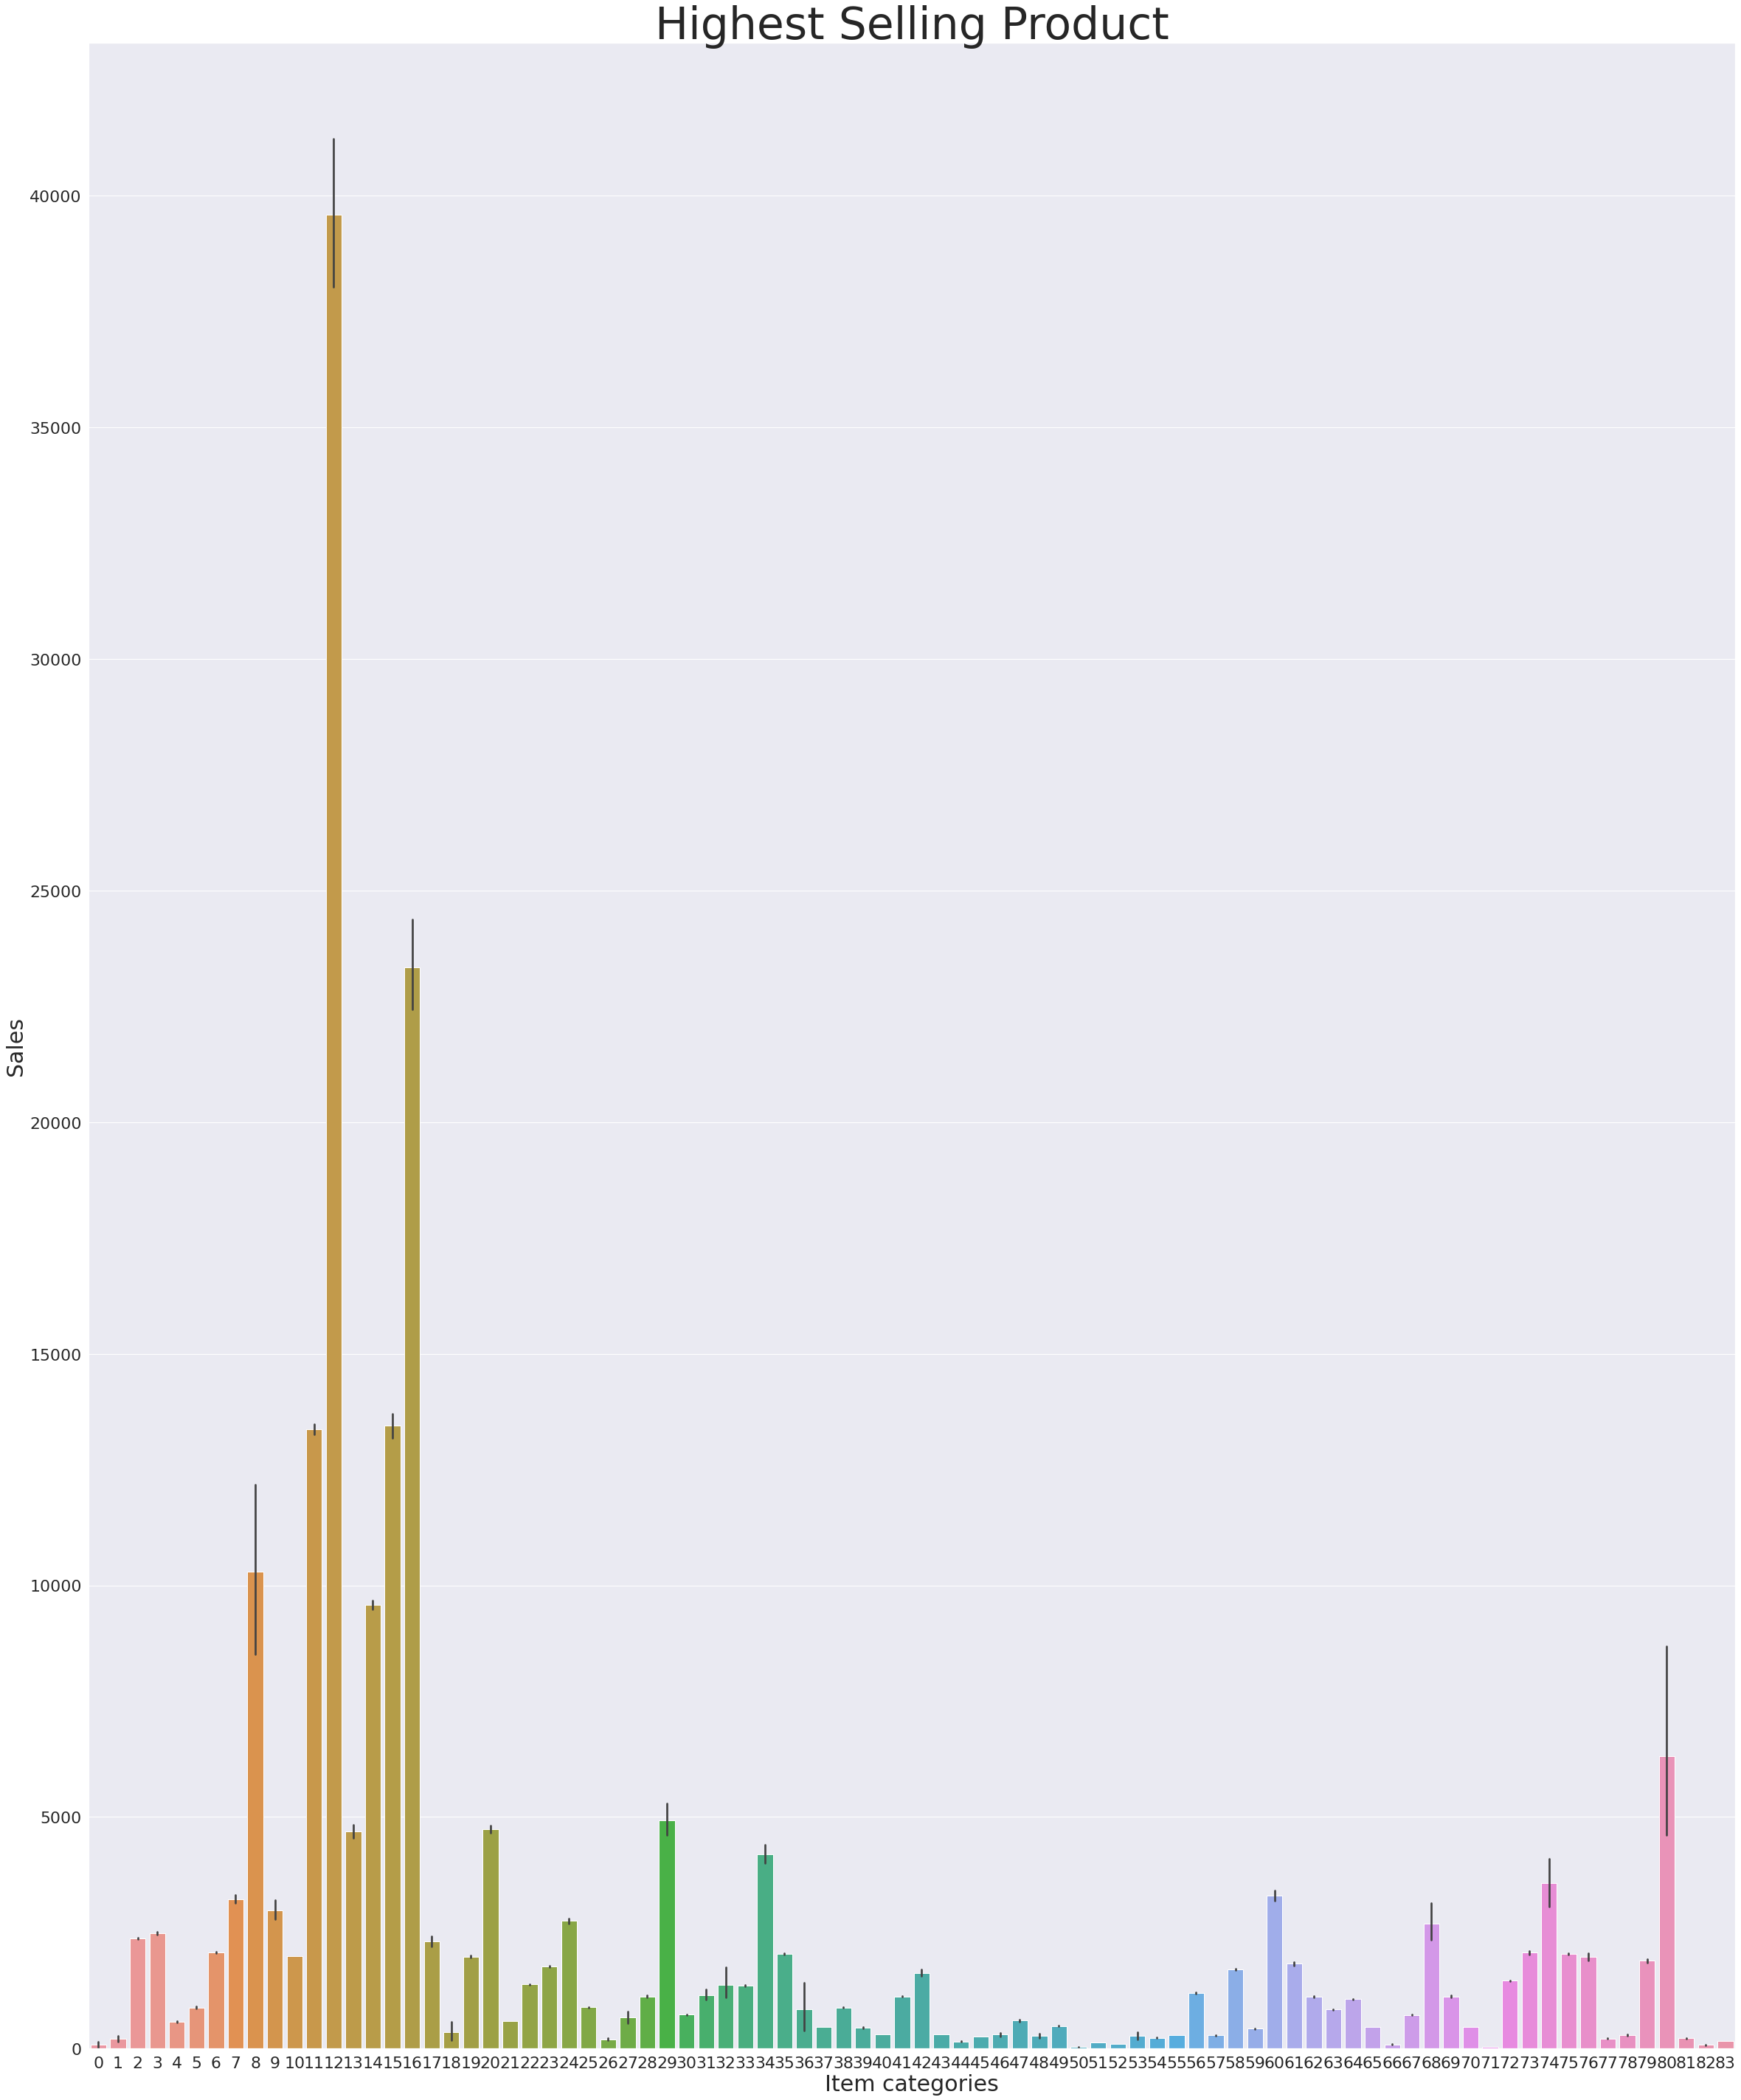

In [48]:
plt.figure(figsize=(40, 50))
x= train_set['item_category_id']
y= train_set['Sales']
sns.barplot(x, y)
plt.title('Highest Selling Product', fontsize = 60)
plt.xlabel('Item categories', fontsize = 30)
plt.ylabel('Sales', fontsize = 30)
plt.show()

In [49]:
highest_selling_itemc= train_set.loc[train_set['item_category_id'] == 12]
highest_selling_itemc

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
16947,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-11-29,10,18323.333333,30.0,549699.999999
16948,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-11-30,10,17990.000000,5.0,89950.000000
16949,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-27,11,22990.000000,2.0,45980.000000
16950,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-28,11,27990.000000,2.0,55980.000000
16951,"Адыгея ТЦ ""Мега""",2,Игровые консоли - PS4,12,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,6675,2013-12-29,11,27990.000000,2.0,55980.000000
...,...,...,...,...,...,...,...,...,...,...,...
2895033,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,13444,2014-09-15,20,22490.000000,1.0,22490.000000
2895034,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект Sony PS4 (500 Gb) Black (CUH-1108A/B0...,13444,2014-04-10,21,22490.000000,1.0,22490.000000
2895035,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект «Sony PS4 (500 Gb) Black (CUH-1108A/B...,13498,2014-11-17,22,20990.000000,1.0,20990.000000
2895036,"Ярославль ТЦ ""Альтаир""",59,Игровые консоли - PS4,12,Комплект «Sony PS4 (500 Gb) Black (CUH-1108A/B...,13498,2014-01-11,22,22490.000000,1.0,22490.000000


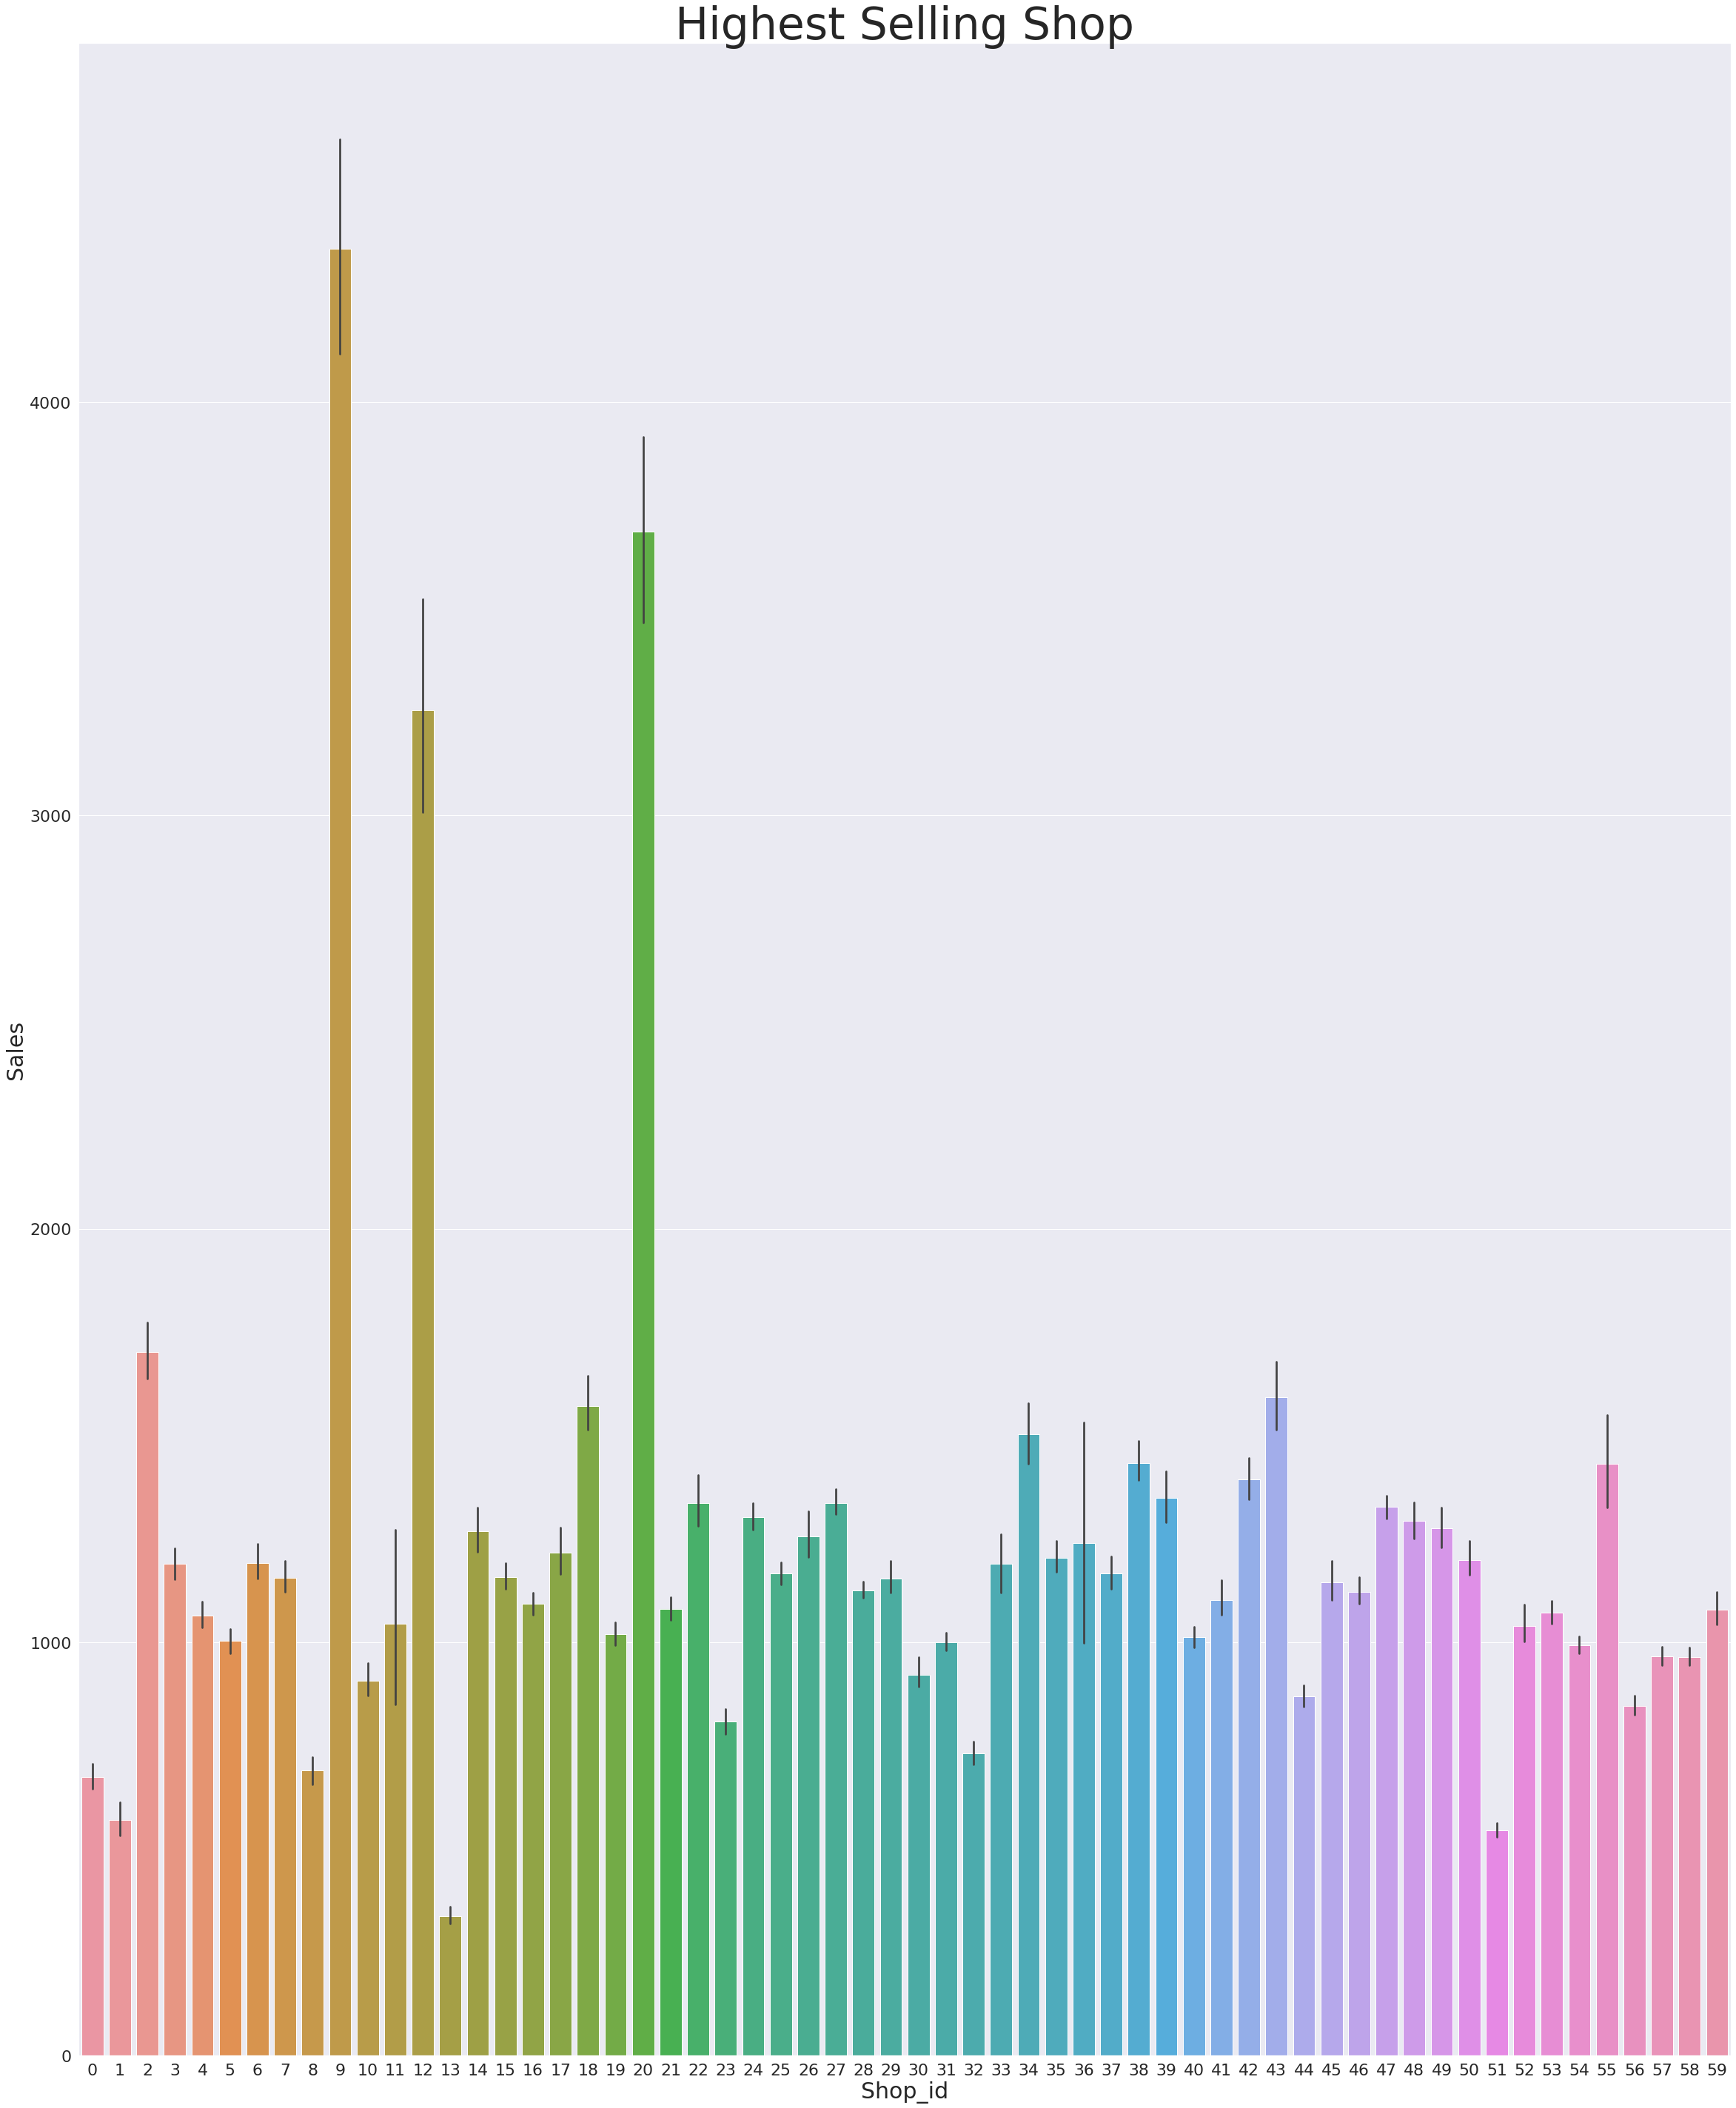

In [50]:
plt.figure(figsize=(40, 50))
x= train_set['shop_id']
y= train_set['Sales']
sns.barplot(x, y)
plt.title('Highest Selling Shop', fontsize = 60)
plt.xlabel('Shop_id', fontsize = 30)
plt.ylabel('Sales', fontsize = 30)
plt.show()

In [51]:
highest_selling_shop= train_set.loc[train_set['shop_id'] == 9]
highest_selling_shop

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
287630,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,2013-05-10,9,1490.000000,2.0,2980.0
287631,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller Charger (Зарядная ст...,5573,2013-04-10,9,599.000000,1.0,599.0
287632,Выездная Торговля,9,Аксессуары - PS3,2,PS Move Motion Controller Charger (Зарядная ст...,5573,2013-05-10,9,599.000000,2.0,1198.0
287633,Выездная Торговля,9,Аксессуары - PS3,2,PS3: Гарнитура беспроводная для PS3 (Wireless ...,5612,2013-04-10,9,3690.000000,1.0,3690.0
287634,Выездная Торговля,9,Аксессуары - PS3,2,PS3: Гарнитура беспроводная для PS3 (Wireless ...,5612,2013-06-10,9,3690.000000,1.0,3690.0
...,...,...,...,...,...,...,...,...,...,...,...
291376,Выездная Торговля,9,Программы - Для дома и офиса,75,Kaspersky Internet Security для Android Russia...,4201,2015-02-10,33,399.000000,110.0,43890.0
291377,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-02-10,21,1999.000000,2.0,3998.0
291378,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-03-10,21,1219.000000,5.0,6095.0
291379,Выездная Торговля,9,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,2014-05-10,21,774.250000,4.0,3097.0


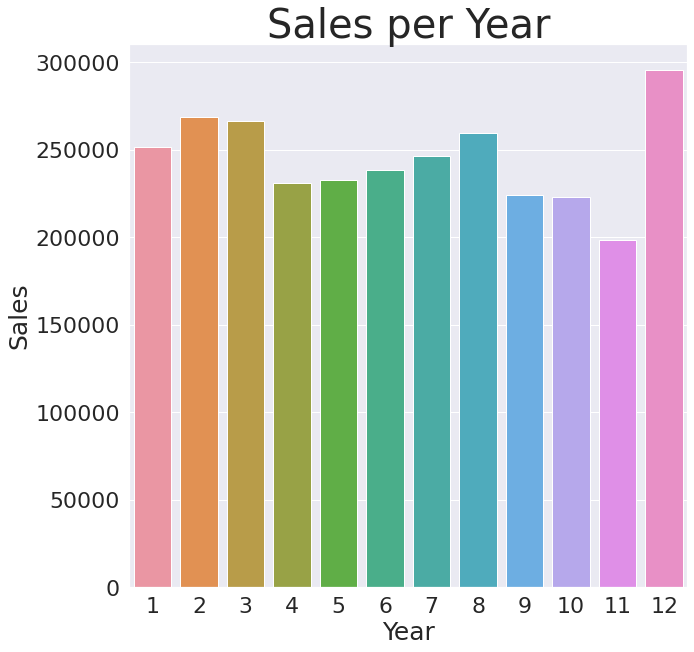

In [52]:
plt.figure(figsize=(10,10))
sns.countplot(months)
plt.title('Sales per Year', fontsize = 40)
plt.xlabel('Year', fontsize = 25)
plt.ylabel('Sales', fontsize = 25)
plt.show()

Text(0, 0.5, 'Sales')

<Figure size 2160x2160 with 0 Axes>

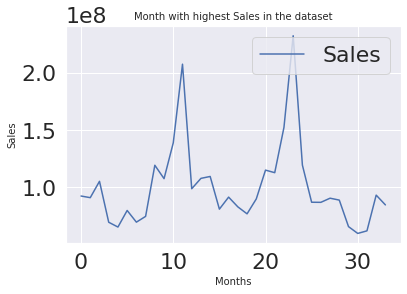

In [53]:
sales_by_month = train_set.groupby(['date_block_num'])[["Sales"]].sum()
plt.figure(figsize=(30,30))
sales_by_month.plot()
plt.title('Month with highest Sales in the dataset', fontsize = 10)
plt.xlabel('Months', fontsize = 10)
plt.ylabel('Sales', fontsize = 10)

In [54]:
sales_max = train_set.groupby(['date_block_num'])['Sales'].sum()
sales_max.max()

232615420.90999845

In [55]:
print(sales_max==232615420.90999845)

date_block_num
0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
20    False
21    False
22    False
23     True
24    False
25    False
26    False
27    False
28    False
29    False
30    False
31    False
32    False
33    False
Name: Sales, dtype: bool


In [56]:
highest_sales_month = train_set[train_set["date_block_num"]==23]
highest_sales_month

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,date,date_block_num,item_price,item_cnt_day,Sales
15563,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,2014-12-18,23,1490.0,1.0,1490.0
15627,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Turtle Beaсh. EarForce P11. Геймерская ст...,5610,2014-12-31,23,1890.0,1.0,1890.0
15652,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Геймпад Gioteck VX-1 беспроводной (VX1PS3...,5616,2014-12-29,23,1190.0,1.0,1190.0
15699,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной красный (...,5631,2014-12-31,23,3290.0,1.0,3290.0
15712,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной прозрачны...,5634,2014-12-16,23,2590.0,1.0,2590.0
...,...,...,...,...,...,...,...,...,...,...,...
2935789,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,2014-12-14,23,139.0,1.0,139.0
2935790,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,2014-07-12,23,139.0,1.0,139.0
2935840,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR6 2*BL,22092,2014-12-21,23,139.0,1.0,139.0
2935841,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR6 2*BL,22092,2014-12-15,23,139.0,1.0,139.0


In [57]:
highest_store_sales = train_set.groupby(['date_block_num', 'shop_name'])['Sales'].sum()

highest_store_sales.max()

15730394.000000501

In [58]:
highest_store_sales=pd.DataFrame(highest_store_sales)
highest_store_sales=highest_store_sales.loc[highest_store_sales['Sales'] == 15730394.000000501]
highest_store_sales

,,Sales
date_block_num,shop_name,
23,"Москва ТРК ""Атриум""",1.573039e+07


In [59]:
highest_item_sales = train_set.groupby(['date_block_num', 'item_category_name'])['Sales'].sum()

highest_item_sales.max()

46487721.9999976

In [60]:
highest_item_sales=pd.DataFrame(highest_item_sales)
highest_item_sales=highest_item_sales.loc[highest_item_sales['Sales'] == 46487721.9999976]
highest_item_sales

,,Sales
date_block_num,item_category_name,
11,Игровые консоли - PS4,4.648772e+07


In [61]:
train_set = train_set[["date_block_num", "shop_id", "item_id", "item_price", "item_cnt_day", "shop_name", "Sales", "item_name"]].groupby(
    ["date_block_num", "shop_id", "item_id"]).agg(
    {"item_cnt_day": "sum", "Sales" : "sum"}).reset_index()
train_set.rename(columns={"item_cnt_day": "item_cnt_month"}, inplace=True)

In [62]:
test1=pd.merge(items, testset)
test2=pd.merge(item_cat, test1)
test = pd.merge(shops,test2)
test

,shop_name,shop_id,item_category_name,item_category_id,item_name,item_id,ID
0,"Адыгея ТЦ ""Мега""",2,PC - Гарнитуры/Наушники,0,PC: Гарнитура HyperX Cloud Core игровая стерео...,5441,23914
1,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS Move Motion Controller (Контроллер движений...,5572,24116
2,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Кабель HDMI Artplays 2 м (ver. 1.4) блистер,5621,25398
3,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной прозрачны...,5634,21533
4,"Адыгея ТЦ ""Мега""",2,Аксессуары - PS3,2,PS3: Контроллер игровой беспроводной серый мет...,5637,25197
...,...,...,...,...,...,...,...
214195,"Ярославль ТЦ ""Альтаир""",59,Служебные,79,Прием денежных средств для 1С-Онлайн,17717,148174
214196,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL LR03-BC2,22087,148487
214197,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL LR06-BC2,22088,148488
214198,"Ярославль ТЦ ""Альтаир""",59,Элементы питания,83,Элемент питания DURACELL TURBO LR 03 2*BL,22091,148489


In [63]:
test=test.drop("ID",1)

In [64]:
test.shape

(214200, 6)

In [65]:
train_set_u = train_set['item_id'].nunique()
test_u = test['item_id'].nunique()
train_set_s = train_set['shop_id'].nunique()
test_s = test['shop_id'].nunique()
print("Total unique item_ids in train_set dataset: ", train_set_u)
print("Total unique item_ids in test dataset: ", test_u )

print("Total unique shop_ids train_set dataset: ", train_set_s)
print("Total unique shop_ids in test dataset: ", test_s)

Total unique item_ids in train_set dataset:  21806
Total unique item_ids in test dataset:  5100
Total unique shop_ids train_set dataset:  60
Total unique shop_ids in test dataset:  42


In [66]:
train_set = train_set[train_set['shop_id'].isin(test['shop_id'].unique())]
train_set = train_set[train_set['item_id'].isin(test['item_id'].unique())]

In [67]:
train_set_u = train_set['item_id'].nunique()
test_u = test['item_id'].nunique()
train_set_s = train_set['shop_id'].nunique()
test_s = test['shop_id'].nunique()
print("Total unique item_ids in train_set dataset: ", train_set_u)
print("Total unique item_ids in test dataset: ", test_u )

print("Total unique shop_ids train_set dataset: ", train_set_s)
print("Total unique shop_ids in test dataset: ", test_s)

Total unique item_ids in train_set dataset:  4716
Total unique item_ids in test dataset:  5100
Total unique shop_ids train_set dataset:  42
Total unique shop_ids in test dataset:  42


In [68]:
test.shape

(214200, 6)

In [69]:
test["item_cnt_month"]=" "

In [70]:
test.info()
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 214200 entries, 0 to 214199
Data columns (total 7 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   shop_name           214200 non-null  object
 1   shop_id             214200 non-null  int64 
 2   item_category_name  214200 non-null  object
 3   item_category_id    214200 non-null  int64 
 4   item_name           214200 non-null  object
 5   item_id             214200 non-null  int64 
 6   item_cnt_month      214200 non-null  object
dtypes: int64(3), object(4)
memory usage: 13.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 600158 entries, 3921 to 1609121
Data columns (total 5 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   date_block_num  600158 non-null  int64  
 1   shop_id         600158 non-null  int64  
 2   item_id         600158 non-null  int64  
 3   item_cnt_month  600158 non-null  float64
 4   Sal

In [71]:
train_set=train_set.drop("Sales", 1)
train_set=train_set.drop("date_block_num", 1)
test= test.drop("item_category_id", 1)
test= test.drop("item_category_name", 1)
test= test.drop("item_name", 1)
test= test.drop("shop_name", 1)

In [72]:
train_x = train_set.drop(['item_cnt_month'], axis=1)
train_y = train_set['item_cnt_month']
test_x = test.drop(['item_cnt_month'], axis=1)
model_lgb = LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, max_depth=6,
              min_child_weight=1, min_split_gain=0.0222415, n_estimators=100,
              num_leaves=32, reg_alpha=0.04, reg_lambda=0.073,
              subsample=0.9)
model_lgb.fit(train_x, train_y)

LGBMRegressor(colsample_bytree=0.9, learning_rate=0.03, max_depth=6,
              min_child_weight=1, min_split_gain=0.0222415, num_leaves=32,
              reg_alpha=0.04, reg_lambda=0.073, subsample=0.9)

In [73]:
sales_prediction = model_lgb.predict(test_x)
sales_prediction

array([2.15259636, 2.15259636, 2.15259636, ..., 3.50020661, 3.4086322 ,
       3.4086322 ])

In [74]:
sales_predict_submission = pd.DataFrame({'ID':test_x.index,'item_cnt_month':sales_prediction})

sales_predict_submission

,ID,item_cnt_month
0,0,2.152596
1,1,2.152596
2,2,2.152596
3,3,2.152596
4,4,2.152596
...,...,...
214195,214195,5.101422
214196,214196,3.500207
214197,214197,3.500207
214198,214198,3.408632


In [75]:
sales_predict_submission.to_csv('./submission.csv', index= False, header= 1)